# Explorations with the Enron Threads

The goal here is to derive several measures that can capture the different dynamics of the conversations in email threads.

In [46]:
import pandas as pd
import numpy as np
import scipy.stats

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from bokeh.plotting import figure, show, output_file, ColumnDataSource
from bokeh.models import HoverTool

output_notebook()

Loading BokehJS ...

#### First some helper functions to enable functionality on other metric calculations

In [33]:
# A function to find the distribution of the time gaps
def findGaps(messages):
    messageTimes = np.asarray([pd.Timestamp(message['time']).tz_convert('UTC') for message in messages])
    return messageTimes[1:] - messageTimes[:-1]

# returns a list of senders in a thread
def getSenders(messageCollection):
    return [message['sender'] for message in messageCollection]

# returns a list of recipients for a given message
def getSetOfRecipients(messageRecipientObject):
    return [recip['email'] for recip in messageRecipientObject['recipients']]

# returns a list of types of recipients of a message
def getTypesOfRecipients(messageRecipientObject):
    return [recip['type'] for recip in messageRecipientObject['recipients']]

# get set-based overviews of participant collections (senders and recievers). concatenates sender and the reciever for a single message
def getInvolvedSetsMerged(messageCollection):
    sendersRecip = [[message['sender']] + getSetOfRecipients(message) for message in messageCollection]
    return np.asarray(sendersRecip)

# get set-based overviews of participant collections (senders and recievers). Leaves sender and the reciever in separate lists
def getInvolvedSetsSeperate(messageCollection):
    sendersRecip = [[[message['sender']], getSetOfRecipients(message)] for message in messageCollection]
    return np.asarray(sendersRecip)

## Interaction Dynamics Measures
### Pace of interaction

This measure captures how high or low pace the thread is through a simple formula -- average time between messages

In [34]:
# Proxy Measure of a single Thread  for "Pace of Interaction", description: median of all time gaps between messages
def threadProxyMeasurePaceOfInteractionAvgGap(thread):
    return np.median(findGaps(thread["messages"])).total_seconds()

### Flow of interaction

This is a measure that aims to capture whether the interaction was consistently flowing or regularly interrupted

In [35]:
# TODO

**Note:** A helper function that contains intermediate data that can be used to derive further metrics.

In [36]:
# research function to estimate proxies for pace of interaction for threads
def estimatePaceOfInteractionForThreadCollection(threadCollection):
    threadGaps = []
    # This is a measure to use as a proxy for the pace of interaction
    paceofInteraction_v1 = []
    for index, row in threadCollection.iterrows():
        gapsWithinAThread = findGaps(row["messages"])
        paceofInteraction_v1.append(np.median(gapsWithinAThread).total_seconds())
        # print ("Median Gap: ", medianGap.total_seconds() )
        threadGaps.append(gapsWithinAThread)
    # alternatively, this can return the threadGaps to come up with alternative proxies to paceOfInteraction
    # Another alternative, just the average
    # paceofInteraction_v2 = [np.sum(gapArray) / len(gapArray) for gapArray in threadGaps]
    return paceofInteraction_v1

## Individual Oriented Measures

### Diversity in Senders
This measure checks whether the senders in a thread vary. Indicative of an active engagement overall.

In [37]:
# Proxy Measure of a single Thread for "Sender Diversity", description: "unique senders / number of messages"
def threadProxyMeasureSenderDiversitySimple(thread):
    return len(np.unique(getSenders(thread["messages"]))) / len(thread["messages"])

# Proxy Measure for diversity within senders using Entropy as a measure"
def threadProxyMeasureSenderDiversityEntropy(thread):
    uniqueSenders, messageCounts = np.unique(getSenders(thread["messages"]), return_counts=True)
    return scipy.stats.entropy(messageCounts)

### Particular ratios of Senders / Receivers and their changes
These are some measures to aim to capture branching and diversity in terms of entries and exits to the discussion

In [38]:
# Proxy Measure for diversity within senders comparing the size of the set of individuals in the begining and the end, a proxy for branching
def threadProxyMeasureParticipantGrowth(thread):
    individualSet = getInvolvedSetsMerged(thread["messages"])
    initialSetSize = len(individualSet[0])
    # the number of unique people involved at the end of the thread
    finalSetSize = len(np.unique(np.concatenate(individualSet)))
    return finalSetSize / initialSetSize

# Proxy Measure for diversity within senders comparing the size of the change in the size of the set of individuals over the thread, a proxy for branching
# deliberately not using set intersections as this might conflate/inflate certain kinds of communications, sticking to the simple size variation instead
def threadProxyMeasureParticipantSizeVariation(thread):
    individualSet = getInvolvedSetsMerged(thread["messages"])
    # get the size of the number of people involved at each message to create a distribution
    sizesOfIndividuals = [len(individualSet) for individualSet in individualSet]
    # for the moment, just estimate the standard deviation of the above distribution of sizes of sets
    return np.std(sizesOfIndividuals)

And some measures to capture the level of engagement within individuals involved.

In [39]:
# Proxy Measure for the level of engagement from the participants of a thread: #active/#allInvolved, an engaged discussion vs. a large audience
def threadProxyMeasureEngagement(thread):
    individualSets = getInvolvedSetsSeperate(thread["messages"])
    allSenders = np.unique(np.concatenate(individualSets[:, 0]))
    allRecievers = np.unique(np.concatenate(individualSets[:, 1]))
    passiveParticipants = np.setdiff1d(allRecievers, allSenders)
    return len(allSenders) / (len(allSenders) + len(passiveParticipants))

** Note: ** A helper function that contains intermediate data that can be used to derive further metrics in terms of diversity in individuals

In [40]:
# A testbed function to test for alternative diversity measures
def findSenderDiversity_v1(threadCollection):
    senderDiversity_v1 = []
    for index, row in threadCollection.iterrows():
        uniqueSenders, messageCounts = np.unique(getSenders(row["messages"]), return_counts=True)
        ent = scipy.stats.entropy(messageCounts)
        skew = scipy.stats.skew(messageCounts)
        iqr = scipy.stats.iqr(messageCounts/float(len(row["messages"])))
        print("Thread: ", index, " length: ", len(row["messages"]), " , with unique senders: ", len(uniqueSenders), " with diversity: ", len(uniqueSenders)/len(row["messages"]), " and with counts: ", messageCounts, " Entropy: ", ent, " Skew: ", skew, " IQR: ", iqr)
        senderDiversity_v1.append(len(uniqueSenders)/len(row["messages"]))
    return senderDiversity_v1

## Graph Theoretic Measures to capture the connection topology

## Building the proxy collection

In [44]:
# A dictionary to bind measure names to function names that calculate them
proxyToFunction = dict([
    ('SenderDiversity', 'threadProxyMeasureSenderDiversitySimple'),
    ('PaceOfInteractionAvgGap', 'threadProxyMeasurePaceOfInteractionAvgGap'),
    ('SenderDiversityEntropy', 'threadProxyMeasureSenderDiversityEntropy'),
    ('ParticipantGrowth', 'threadProxyMeasureParticipantGrowth'),
    ('ParticipantSizeVariation', 'threadProxyMeasureParticipantSizeVariation'),
    ('Engagement', 'threadProxyMeasureEngagement'),
    ])

def estimateThredProxiesFromThreadCollection(threadCollection, threadMeasures):
    threadProxies = []
    for index, row in threadCollection.iterrows():
        proxiesForThread = []
        #proxiesForThread.append(row['threadId'])
        for measureName in threadMeasures:
            proxiesForThread.append(globals()[proxyToFunction[measureName]](row))
        threadProxies.append(proxiesForThread)
    return np.asarray(threadProxies)


# Load the email data objects
threadObjects = pd.read_json("threads-50.json")
threadObjects.head()

givenThreadMeasureNames = ["threadID"]
computedThreadMeasureNames = ["SenderDiversity", "PaceOfInteractionAvgGap", "SenderDiversityEntropy", "ParticipantGrowth", "ParticipantSizeVariation", "Engagement"]
proxies = estimateThredProxiesFromThreadCollection(threadObjects, computedThreadMeasureNames)


## Visualising the results

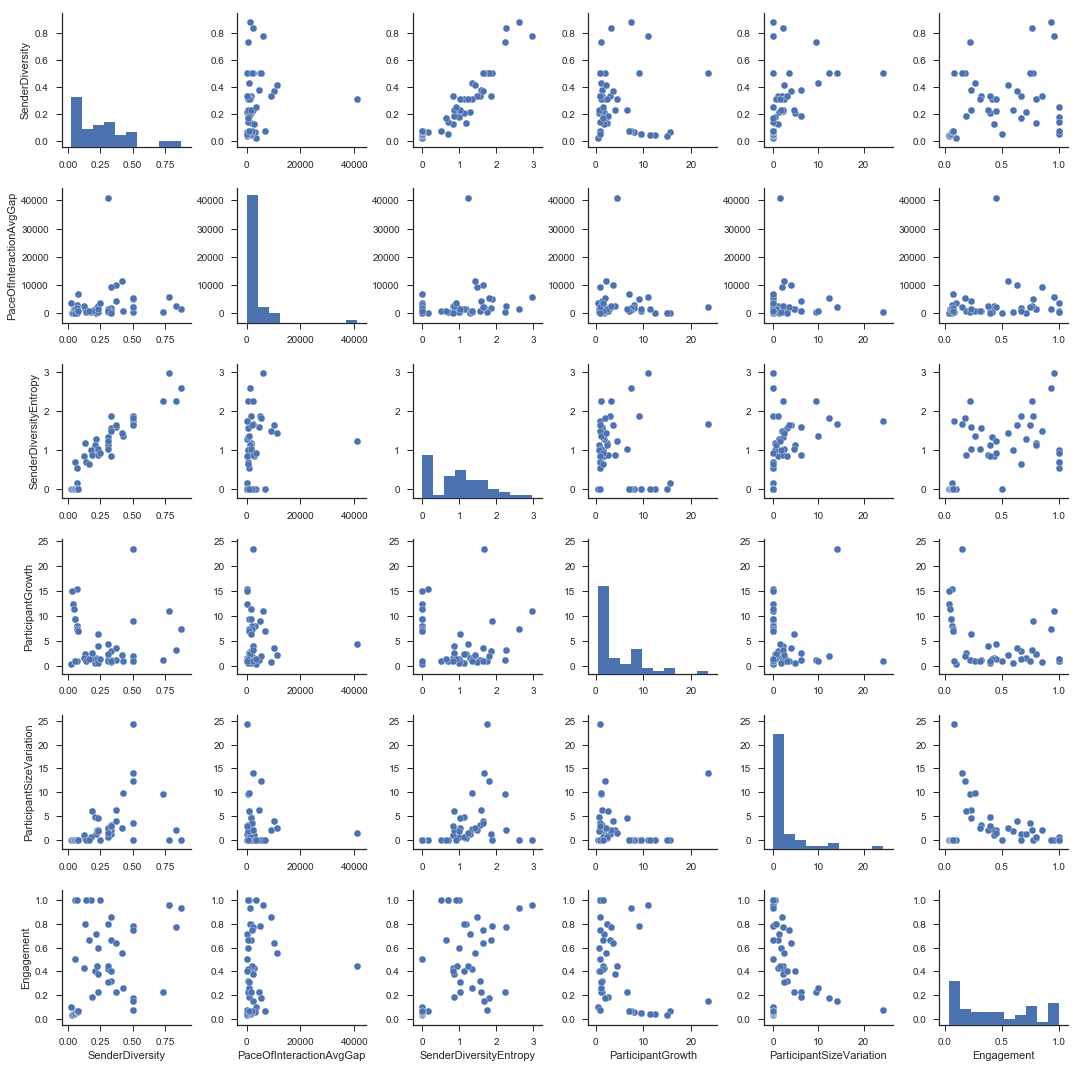

In [47]:
sns.set(style="ticks")

df = pd.DataFrame(data=proxies, columns=computedThreadMeasureNames)
sns.pairplot(df)
plt.show()

# hover = HoverTool(
#         tooltips=[
#             ("index", "$index"),
#             ("threadID", "@threadID"),ProxyMeaspro
#             ("senderDiversity", "@senderDiversity"),
#             ("paceOfInteraction", "@paceOfInteraction"),
#             ("senderEntropy", "@senderEntropy"),
#             ("ParticipantGrowth", "@ParticipantGrowth"),
#         ]
#     )
#
# source = ColumnDataSource(data=dict(
#     threadID = proxies[:, 0],
#     senderDiversity = proxies[:, 1].astype(float),
#     paceOfInteraction= proxies[:, 2].astype(float),
#     senderEntropy= proxies[:, 5].astype(float),
#     ParticipantGrowth= proxies[:, 6].astype(float),
# ))
#
# p = figure(title = "Thread Proxies")
# p.circle('senderDiversity', 'paceOfInteraction', fill_alpha=0.2, size=10, source=source)
# p.add_tools(hover)
#
# p2 = figure(title = "Thread Proxies 2")
# p2.circle('senderEntropy', 'ParticipantGrowth', fill_alpha=0.2, size=10, source=source)
# p2.add_tools(hover)
#